# Задание 1


### Целью этого задания является знакомство со стандартными контейнерами и некторыми функциями из стандартных библиотек для машинного обучения.

Напишите наивный байесовский классификатор и сравните его с реализацией NaiveBayesClassifier из библиотеки nltk.

Написанный вами классификатор должен обладать следубщими свойствами:
<ul>
<li>В предложенном интерфейсе класса должны быть реализованы все методы и все поля. Для их хранения предподсчитанных данных рекомендуется использовать контейнеры Counter или defaultdict из библиотеки collections. Для предсказания категории рекомендуется использовать numpy.</li>
<li>Должна использоваться модель, предложенная в теории.</li>
<li>Точность предсказаний не менее <b>0.9</b>!</li>
<li>После реализации класса протестируйте его с помощью кроссвалидации с k=10. Рекомендуется использовать класс KFold из библиотеки sklearn.</li>
<li>Постройте постройте диаграмму размаха для классификаторов (своего и из библиотеки).</li>
</ul>

### Теория

Теория находится в файле problems1-theory.pdf

# Решение

In [4]:
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score
from nltk import NaiveBayesClassifier as NBC
from nltk.tokenize import word_tokenize
from matplotlib import pyplot as plt
from tqdm import tqdm

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Прочитайте данные из файла

In [5]:
data_path = "ham-spam.csv"

In [6]:
sheet = pd.read_csv(data_path)

### Реализуйте все методы в классе NaiveBayes

In [7]:
class NaiveBayes(object):
    """
    Наивный байесовский классификатор.
    Для каждого входного сообщения слово учитывается один раз при расчете итоговой вероятности.

    Parameters
    ----------
    category_priors : default | None, optional, default None
        Априорные вероятности категорий.
        Если None, то классификатор должен сам их вычислить.

    weight : float, optional, default 1
        Вес одного слова в формуле взвешенной вероятности

    supposed_prob : float, optional, default 0.5
        Предполагаемая вероятность слова в категории
    """

    def __init__(self, category_priors=None, weight=1, supposed_prob=0.5):
        self.category_priors = category_priors        
        self.weight = weight
        self.supposed_prob = supposed_prob
        
        # Количество отдельных слов в заданной категории
        self.feature_category_counts = defaultdict(Counter)

        # Количество всех документов в данной категории
        self.category_doc_counts = Counter()

        # Количество встреч слова во всех сообщениях
        self.feature_counts = Counter()
        
        # Categories names
        self.categories = None

        # Total number of features in categories and at all
        self.features = None
        self.category_features = Counter()

    def fit(self, x_train, y_train):
        """
        Производит обучение наивного байесовского классификатора.

        Parameters
        ----------
        x_train : list of list of str | list of str | str
            Входной текст описывается строкой, которую будет токенизирована по пробелу.
            Если строка не токенизирована, то текст должен быть токенизирован.
            Может быть передано несколько сообщений, которые будут токенезированы, если необходимо.

        y_train : list of str
            содержит список меток (названий категорий) для сообщений из x_train

        Returns
        -------
        self : object
            Returns self
        """
        
        if isinstance(x_train, str):
            x_train = [x_train]
            
        for i in range(len(x_train)):
            if isinstance(x_train[i], str):
                x_train[i] = [x_train[i]]
                
            line = []
            for j in x_train[i]:
                line.extend(j.split())
                
            x_train[i] = line
        
        # Подсчитываем количество категорий, документов и слов в каждой категории
        # и количество встреч слова во всех сообщениях
        for i in range(len(y_train)):
            self.feature_category_counts[y_train[i]].update(x_train[i])
            self.feature_counts.update(x_train[i])
        self.category_doc_counts.update(y_train)
        
        self.categories = list(self.category_doc_counts.keys())
        
        self.features = sum(list(self.feature_counts.values()))
        for cat_name in self.get_categories():
            self.category_features[cat_name] = sum(list(self.feature_category_counts[cat_name].values()))
        
        # Если априорные вероятности категорий не заданы, то надо аппроксимировать их
        if self.category_priors is None:
            self.category_priors = dict()
            for cat_name in self.get_categories():
                self.category_priors[cat_name] = self.category_features[cat_name] / self.features
        
        return self

    def predict(self, text):
        """
        Предсказывает метки категорий для text.

        Parameters
        ----------
        text : list of list of str | list of str | str
            Входной текст описывается строкой, которую будет токенизирована по пробелу.
            Если строка не токенизирована, то текст должен быть токенизирован.
            Может быть передано несколько сообщений, которые будут токенезированы, если необходимо.

        Returns
        -------
        categories : list of str
            Возвращает названия категорий для text.
        """
        
        categories = []
        
        if isinstance(text, str):
            text = [text]
            
        for i in range(len(text)):
            if isinstance(text[i], str):
                text[i] = [text[i]]
                
            line = []
            for j in text[i]:
                line.extend(j.split())
            
            probs = self.get_probs(line)
            argmax = 0
            for i in range(len(probs)):
                if probs[i] > probs[argmax]:
                    argmax = i
                    
            categories.append(list(self.get_categories())[argmax])
                
        return categories

    def score(self, text, labels):
        """
        Возвращает точность предсказаний на text для правильных категорий labels.

        Parameters
        ----------
        text : list of list of str | list of str | str
            Входной текст описывается строкой, которую будет токенизирована по пробелу.
            Если строка не токенизирована, то текст должен быть токенизирован.
            Может быть передано несколько сообщений, которые будут токенезированы, если необходимо.
        labels : list of str
            Список категорий для каждого токена из text.

        Returns
        -------
        acc : float
            Точность предсказания.
        """
        if isinstance(text, str):
            text = [text]
            
        for i in range(len(text)):
            if isinstance(text[i], str):
                text[i] = [text[i]]
                
            line = []
            for j in text[i]:
                line.extend(j.split())
                
        categories = self.predict(text)        
        accurate = np.where(categories == labels)
        
        return len(accurate[0]) / len(labels)

    def get_probs(self, text):
        """
        Считает вероятности принадлежности текста (text) к каждой из категорий

        Parameters
        ----------
        text : list of str | str
            Входной текст описывается строкой, которую будет токенизирована по пробелу.
            Если строка не токенизирована, то текст должен быть токенизирован.

        Returns
        -------
        probs : list of float
            Возвращает вероятности probs всех категорий для текста text
            в порядке их следования в self.category_doc_counts.
        """
        if isinstance(text, str):
            text = text.split()

        return [self.get_category_prob(cat_name, text) for cat_name in self.get_categories()]

    def get_category_prob(self, cat, text):
        """
        Считает логарифм вероятность принадлежности сообщения text к категории cat.

        Parameters
        ----------
        cat : str
            Название категории.

        text : list of str
            Список из слов.

        Returns
        -------
        log_prob : float
            Возвращает логарифм вероятности категории cat для текста text.
        """
        log_prob = log(self.category_priors[cat])
        for word in text:
            weighted_prob = self.get_weighted_feature_prob(cat, word)
            if weighted_prob == 0:
                weighted_prob = self.supposed_prob
            log_prob += log(weighted_prob)

        return log_prob

    def get_weighted_feature_prob(self, cat, feature):
        """
        Вычисляет взвешенную вероятность P(Слово|Категория).

        Parameters
        ----------
        cat : str
            Название категории.

        feature : str
            Слово из текста.

        Returns
        -------
        prob : float
            Возвращает взвешенную вероятность слова feature при условии категории cat.
        """
        unweighted_prob = self.feature_category_counts[cat][feature] / self.category_features[cat]
        return (self.weight * self.supposed_prob + self.features * unweighted_prob) / (self.weight + self.features)

    def get_categories(self):
        """
        Возвращает список названий всех категорий.
        Returns
        -------
        cat_list : list of str
        """
        return self.categories
pass


### Сравните вашу реализацию и реализацию из библиотеки nltk

Для использования классификатора из библиотеки не забудьте предподготовить данные. Для подсчета точности этого классификатора можете использовать accuracy_score из метрик sklearn. Для подсчета точности предсказаний вашего классификатора используйте функцию score, которую вы опишете.

In [8]:
# Предобработка данных для классификатора nltk, если требуется
labels = sheet.values[:, 0]
msgs0 = sheet.values[:, 1]
words = set()
msgs = []
msgwords = [set() for i in range(len(msgs0))]
for i in tqdm(range(len(msgs0))):
    msgs.append(msgs0[i].split())
    msgwords[i].update(msgs[i])
    words.update(msgs[i])
    
labels = np.array(labels)
msgs = np.array(msgs)

100%|████████████████████████████████████████████████████████████████████████████| 2893/2893 [00:00<00:00, 7649.81it/s]


In [9]:
data = []
for i in tqdm(range(len(msgs))):
    data.append(({word: (word in msgwords[i]) for word in words}, labels[i]))
    
data = np.array(data)

100%|██████████████████████████████████████████████████████████████████████████████| 2893/2893 [00:59<00:00, 48.48it/s]


In [10]:
# Используйте процедуру KFold для проверки качества классификаторов
splits = KFold(len(msgs), n_folds=10, shuffle=True)
nltk_accs = []
for train_index, test_index in tqdm(list(splits)):
    x_train, x_test = msgs[train_index], msgs[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
    data_train = data[train_index]
    data_test = data[test_index, 0]
    
    nltk_classifier = NBC.train(data_train)
    
    nltk_pred = nltk_classifier.classify_many(data_test)
    
    nltk_acc = accuracy_score(nltk_pred, y_test)
    
    nltk_accs.append(nltk_acc)

100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [1:22:11<00:00, 493.13s/it]


In [11]:
# Используйте процедуру KFold для проверки качества классификаторов
accs = []
for train_index, test_index in tqdm(list(splits)):
    x_train, x_test = msgs[train_index], msgs[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
    data_train = data[train_index]
    data_test = data[test_index, 0]
    
    classifier = NaiveBayes()
    classifier.fit(x_train, y_train)
    
    pred = classifier.predict(x_test)
    
    acc = accuracy_score(pred, y_test)
    
    accs.append(acc)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:25<00:00,  2.56s/it]


In [13]:
print(accs)
print(nltk_accs)

[0.98620689655172411, 0.97241379310344822, 0.99310344827586206, 0.99307958477508651, 0.98961937716262971, 0.98961937716262971, 0.99307958477508651, 0.97923875432525953, 0.98961937716262971, 0.99307958477508651]
[0.97586206896551719, 0.96551724137931039, 0.95862068965517244, 0.94809688581314877, 0.97231833910034604, 0.94809688581314877, 0.96193771626297575, 0.94463667820069208, 0.92387543252595161, 0.96193771626297575]


### Постройте графики размаха для двух классификаторов на одной фигуре.

Рекомендуется использовать встроенные функции построения графиков в pandas.

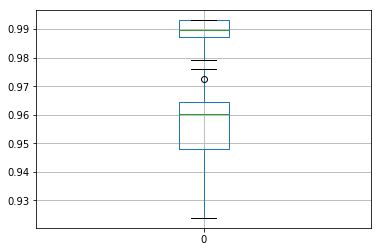

In [16]:
nltk_box = pd.DataFrame(nltk_accs)
box = pd.DataFrame(accs)
nltk_box.boxplot()
box.boxplot()